In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
from os.path import abspath
from PIL import Image
from ModelCNN import project_01, normalize_im
from skimage.segmentation import chan_vese
from skimage import io
from xml.dom import minidom
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
#Zacztanie predykcji i wizualizacja 
def czytaj_rezultat (filename, czy_obraz=True):
    matfile = h5py.File(filename, 'r')
    Images = np.squeeze(np.array(matfile['prediction'][()]))
    if (czy_obraz):
        grey = plt.cm.gray
        plt.imshow(Images[0,:,:], cmap=grey)
    return(Images)

#Wizualizacja wyjściowych danych
def plot_results(file, nr):
    ground = io.imread(file)
    grey = plt.cm.gray
    plt.imshow(ground[nr,:,:], cmap = grey)
    return(ground)

#Ustalanie wyników na podstawie obrazów zwróconych przez model
def wyciagnij_wspolzedne(Image_stack, kwantyl = 99):
    K, M , N = Image_stack.shape
    wyniki_x = []
    wyniki_y = []
    for i in range(K):
        prog  = np.percentile(Image_stack[i,:,:],kwantyl)
        points = np.where(Image_stack[i,:,:]>prog)
        wyniki_y.append(np.mean(points[0]))
        wyniki_x.append(np.mean(points[1]))
    return([np.array(wyniki_x), np.array(wyniki_y)])

#Wczytywanie danych zapisanych w formacie xml
def read_xml(files):
    xmldoc = minidom.parse(files)
    spot_list = xmldoc.getElementsByTagName('Spot')

    x_pos = []
    y_pos = []
    for info in spot_list:
        x_pos.append(float(info.attributes['POSITION_X'].value)*8)
        y_pos.append(float(info.attributes['POSITION_Y'].value)*8)
        
#Funkcja generująca i zapisująca obrazy dla klatek, dla których wystąpiły wyraźne różnice we wskazaniach modeli
def wyjasnij_roznice(roznice, czy_x = True):
    model = []
    matlab = []
    ground = io.imread(movies[0])
    grey = plt.cm.gray
    if czy_x:
        for i in roznice:
            i = i.astype(int)
            t = wyniki_model[0][i+1]/8
            t_int = int(t)
            model.append(t)
            matlab.append(wyniki_mat[i]/8)
            plt.imshow(ground[(i+1),:,(t_int-15):(t_int+15)], cmap = grey)
            plt.savefig("Comparison/shot"+str(i+1)+'_x')
            plt.close()
    else:
        for i in roznice:
            i = i.astype(int)
            t = wyniki_model[1][i+1]/8
            t_int = np.round(t,0).astype(int)
            model.append(t)
            matlab.append(wyniki_mat_y[i]/8-80)
            plt.imshow(ground[i.astype(int)+1,(t_int-10):(t_int+10),:], cmap=grey)
            plt.savefig("Comparison/shot"+str(i+1)+'_y')
            plt.close()
    return np.array([model, matlab])        

In [3]:
#ważne ścieżki do rezultatów i filmów
important_results = ['results/gm_whole_results.hdf5','results_tgm1.hdf5', 'results/tgm9_results.hdf5']
movies = ['Tif_files/golding_movie_whole.tif', 'trackmate_movie1.tif']
grey = plt.cm.gray

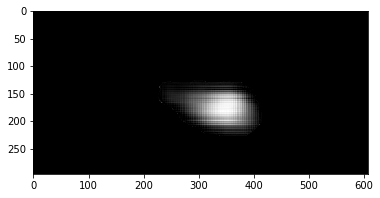

In [4]:
#Wczytanie rezutatu oraz ustalenie wyników
Images = czytaj_rezultat(important_results[0])
wyniki_model =  wyciagnij_wspolzedne(Images, 99.8)

In [79]:
wyniki_model[0]

array([350.23529412, 350.23529412, 330.36871508, ..., 166.05277778,
       174.875     , 188.04444444])

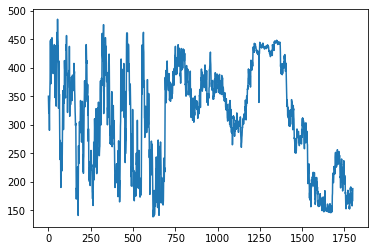

In [6]:
#Wizualizacja i zapisanie wyników - współrzędne x
plt.plot(wyniki_model[0][1:])
plt.savefig('wyniki_x_model.png')

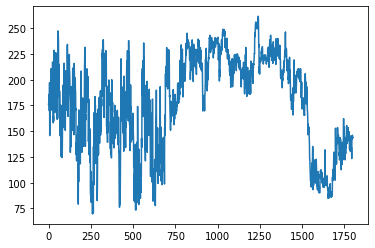

In [7]:
#Wizualizacja i zapisanie wyników - współrzędne y
plt.plot(wyniki_model[1])
plt.savefig('wyniki_y_model.png')

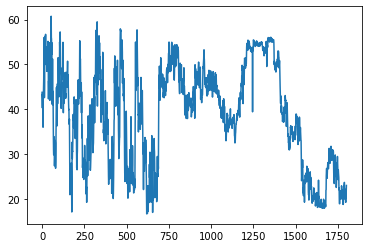

In [6]:
#Zaczytanie wyników uzyskanych algorytmem Chana-Vese
octave = sio.loadmat('results/timeseries_new_param.mat')
plt.plot(octave['meanx'][0])
plt.savefig('wyniki_ChanVese_x.png')    

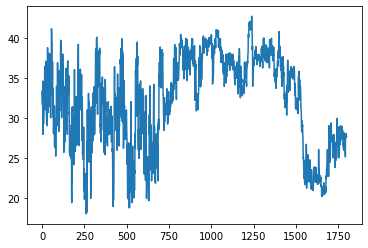

In [7]:
plt.plot(octave['meany'][0])
plt.savefig('Wyniki_ChanVese_y.png')

In [8]:
#Przetransformowanie wyników do porównania
wyniki_mat  = [8*x for x in octave['meanx'][0]]
wyniki_mat_y = [8*x-80 for x in octave['meany'][0]]

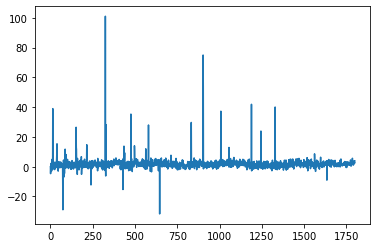

In [9]:
#Wykres różnic - współrzędne_x
differences_x = np.array(wyniki_model[0][1:])-np.array(wyniki_mat)
plt.plot(differences_x)
plt.savefig('differences_x.png')

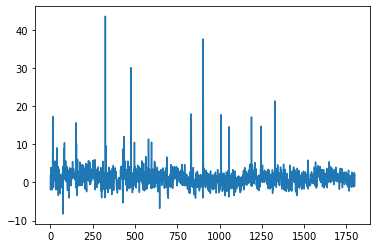

In [10]:
#Wykres różnic - współrzędne y 
differences_y = np.array(wyniki_model[1][1:])-np.array(wyniki_mat_y)
plt.plot(differences_y)
plt.savefig('differences_y.png')

In [13]:
#Średnia różnica
srednia_x_roz = np.mean(differences_x)
srednia_y_roz = np.mean(differences_y)
print(srednia_x_roz)
print(srednia_y_roz)

1.9248883711177802
1.2009583883610342


In [11]:
#Ustalenie na dla których klatek wystąpiły różnice
anomalie_x = np.squeeze(np.where(abs(differences_x) >40 ))
anomalie_y = np.squeeze(np.where(abs(differences_y) >20))

In [12]:
anomalie_x+1

array([ 326,  903,  904,  905, 1190, 1330])

In [13]:
anomalie_y+1

array([ 326,  477,  904,  905, 1330])

In [89]:
#Wygenerowanie i zapisanie obrazków do porówania wyników modeli
roznice_x = wyjasnij_roznice(anomalie_x)
roznice_y = wyjasnij_roznice(anomalie_y, False)

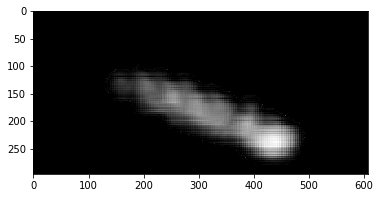

In [103]:
plt.imshow(Images[1330,:,:], cmap = grey)
plt.savefig('Model_1330y.png')

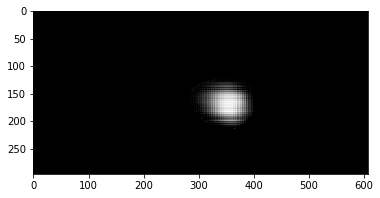

In [107]:
plt.imshow(Images[100,:,:], cmap=grey)
plt.savefig('Kadr_100.png')

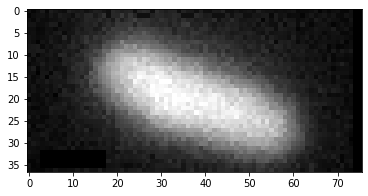

In [108]:
ground = plot_results(movies[0], 79)
plt.savefig('golding_original_79.png')

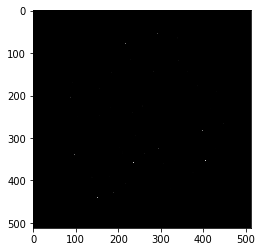

In [110]:
to_text = czytaj_rezultat('to_show_tubes.hdf5')
plt.savefig('show_tubes.png')

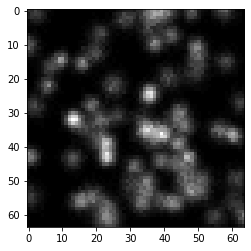

In [8]:
ground = io.imread('dataset_and_csv/tgm8.tif')

plt.imshow(ground[40,:,:], cmap=grey)
plt.savefig('example8.png')

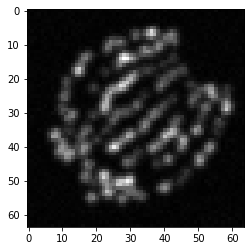

In [115]:
ground_3 = io.imread('Tif_files/testStack_SimulatedMicrotubules.tif')

plt.imshow(ground_3[0,:,:], cmap=grey)
plt.savefig('simulated.png')

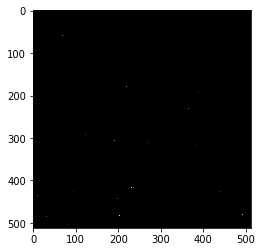

In [5]:
to_text = czytaj_rezultat('to_show8.hdf5')
plt.savefig('show_8.png')

## Predykowanie szeregu

In [29]:
#Dzielimy najpierw zbiór ze względu na niejednorodną wariancję
#Następnie dzielimy na zbiór treningowy i testowy
scaler = MinMaxScaler(feature_range=(0, 1))
scaler2 =MinMaxScaler(feature_range=(0,1 ))
wyniki_model[0] = scaler.fit_transform(wyniki_model[0].reshape(-1,1))
wyniki_model[1] = scaler2.fit_transform(wyniki_model[1].reshape(-1,1))


wyniki_x1 = wyniki_model[0][:745]
wyniki_x2 = wyniki_model[0][745:]

x1_train = wyniki_x1[:600]
x1_test = wyniki_x1[600:]
x2_train = wyniki_x2[:800]
x2_test = wyniki_x2[800:]

wyniki_y1 = wyniki_model[1][:745]
wyniki_y2 = wyniki_model[1][745:]
y1_train = wyniki_y1[:600]
y1_test = wyniki_y1[600:]
y2_train = wyniki_y2[:800]
y2_test = wyniki_y2[800:]

In [45]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [30]:
look_back = 10
trainX, targetY  = create_dataset(x1_train, look_back)
testX, testY = create_dataset(x1_test, look_back)

In [65]:
look_back = 10
batch_size=1
trainX, targetY  = create_dataset(x1_train, look_back)
testX, testY = create_dataset(x1_test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, targetY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

Epoch 1/1
 - 14s - loss: 0.0455
Epoch 1/1
 - 14s - loss: 0.0491
Epoch 1/1
 - 14s - loss: 0.0480
Epoch 1/1
 - 14s - loss: 0.0424
Epoch 1/1
 - 14s - loss: 0.0336
Epoch 1/1
 - 14s - loss: 0.0194
Epoch 1/1
 - 14s - loss: 0.0128
Epoch 1/1
 - 14s - loss: 0.0101
Epoch 1/1
 - 14s - loss: 0.0094
Epoch 1/1
 - 14s - loss: 0.0092
Epoch 1/1
 - 14s - loss: 0.0091
Epoch 1/1
 - 14s - loss: 0.0089
Epoch 1/1
 - 14s - loss: 0.0089
Epoch 1/1
 - 14s - loss: 0.0087
Epoch 1/1
 - 14s - loss: 0.0088
Epoch 1/1
 - 14s - loss: 0.0088
Epoch 1/1
 - 14s - loss: 0.0086
Epoch 1/1
 - 14s - loss: 0.0087
Epoch 1/1
 - 14s - loss: 0.0086
Epoch 1/1
 - 14s - loss: 0.0085
Epoch 1/1
 - 14s - loss: 0.0087
Epoch 1/1
 - 14s - loss: 0.0085
Epoch 1/1
 - 14s - loss: 0.0084
Epoch 1/1
 - 14s - loss: 0.0084
Epoch 1/1
 - 14s - loss: 0.0083
Epoch 1/1
 - 14s - loss: 0.0083
Epoch 1/1
 - 14s - loss: 0.0082
Epoch 1/1
 - 14s - loss: 0.0082
Epoch 1/1
 - 14s - loss: 0.0081
Epoch 1/1
 - 14s - loss: 0.0081
Epoch 1/1
 - 14s - loss: 0.0080
Epoch 1/

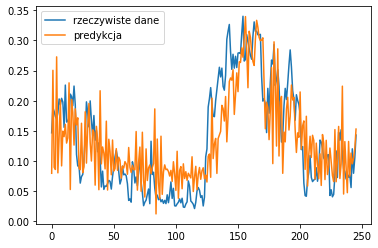

In [63]:
plt.plot(x2_test[11:], label = 'rzeczywiste dane')
plt.plot(testPredict, label = 'predykcja')
plt.legend(loc="upper left")
plt.savefig("predykcje_modelu_Y.png")

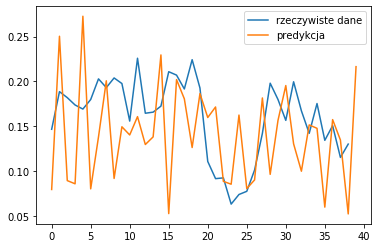

In [64]:
plt.plot(x2_test[11:50], label = 'rzeczywiste dane')
plt.plot(testPredict[:40], label = 'predykcja')
plt.legend(loc="upper right")
plt.savefig("predykcje_zoom_y.png")

In [53]:
look_back = 10
batch_size=1
trainX, targetY  = create_dataset(x2_train, look_back)
testX, testY = create_dataset(x2_test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, targetY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

Epoch 1/1
 - 21s - loss: 0.0088
Epoch 1/1
 - 20s - loss: 0.0072
Epoch 1/1
 - 20s - loss: 0.0075
Epoch 1/1
 - 19s - loss: 0.0079
Epoch 1/1
 - 19s - loss: 0.0085
Epoch 1/1
 - 19s - loss: 0.0091
Epoch 1/1
 - 19s - loss: 0.0099
Epoch 1/1
 - 19s - loss: 0.0095
Epoch 1/1
 - 19s - loss: 0.0119
Epoch 1/1
 - 19s - loss: 0.0129
Epoch 1/1
 - 20s - loss: 0.0138
Epoch 1/1
 - 20s - loss: 0.0147
Epoch 1/1
 - 20s - loss: 0.0154
Epoch 1/1
 - 20s - loss: 0.0159
Epoch 1/1
 - 19s - loss: 0.0162
Epoch 1/1
 - 19s - loss: 0.0164
Epoch 1/1
 - 19s - loss: 0.0145
Epoch 1/1
 - 20s - loss: 0.0174
Epoch 1/1
 - 20s - loss: 0.0180
Epoch 1/1
 - 20s - loss: 0.0179
Epoch 1/1
 - 20s - loss: 0.0182
Epoch 1/1
 - 20s - loss: 0.0181
Epoch 1/1
 - 19s - loss: 0.0173
Epoch 1/1
 - 19s - loss: 0.0166
Epoch 1/1
 - 19s - loss: 0.0142
Epoch 1/1
 - 17s - loss: 0.0099
Epoch 1/1
 - 17s - loss: 0.0071
Epoch 1/1
 - 17s - loss: 0.0055
Epoch 1/1
 - 17s - loss: 0.0042
Epoch 1/1
 - 17s - loss: 0.0032
Epoch 1/1
 - 18s - loss: 0.0028
Epoch 1/